<a href="https://colab.research.google.com/github/RashaAlshawi/DAU-Net-for-Automated-Infrastructure-Inspection/blob/main/NLP_BasedPasswordMemorabilityAid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**`Note: This work is in progress`**    



`**NLP-Based Password Memorability Aid**`

 In this research, deep learning models are exploited to build a password memorability aid. This memorability aspect comes in the form of a generated story of 4 to 5 sentences and acts as an extension to the password in terms of visual memorability.



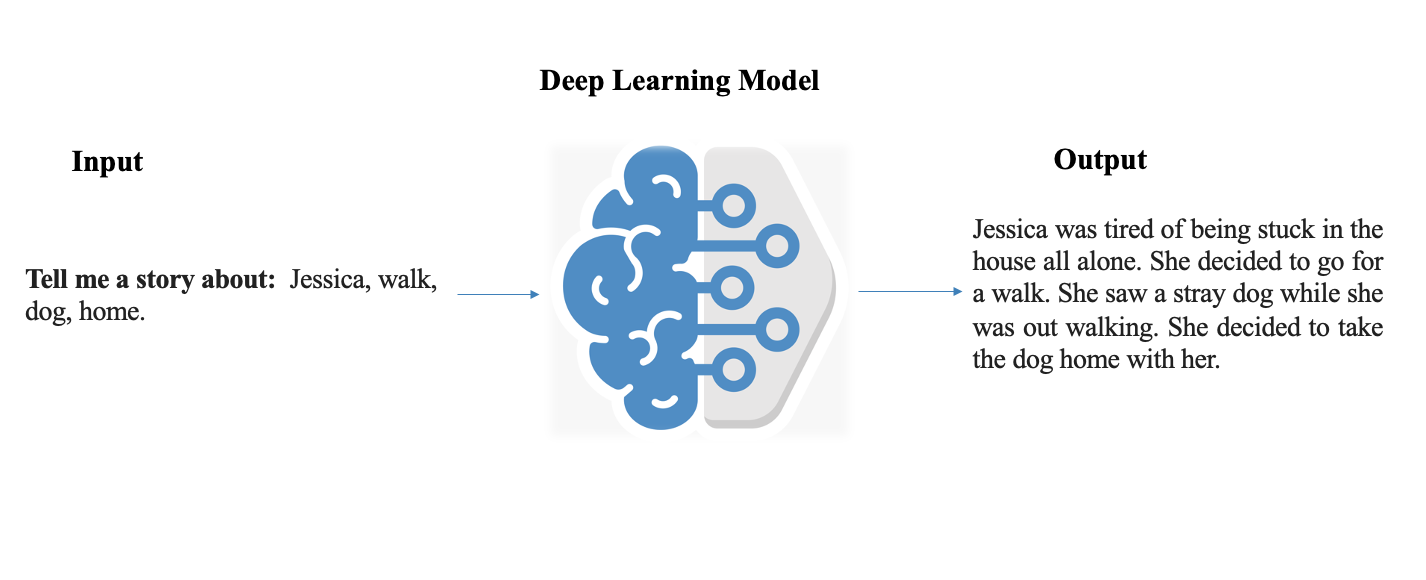

In [ ]:
#@title Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
!pip install -U spacy
!pip install keybert
import spacy
from keybert import KeyBERT
from collections import Counter, OrderedDict
from tqdm.notebook import tqdm
import os
import nltk
import re
from nltk.stem import *
!pip install nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
#Load SpaCy's model
!python -m spacy download en_core_web_sm
spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load Story Cloze Dataset
data=pd.read_csv('/content/drive/MyDrive/ROCStories_generated_wrong_endings_KDE_sampling.csv')

In [ ]:
data.head(2)

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding
0,8bbe6d11-1e2e-413c-bf81-eaea05f4f1bd,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,David enjoys his unusual dinner.,"After a few weeks, he started to feel much bet...",2
1,0beabab2-fb49-460e-a6e6-f35a202e3348,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...,Tom later donated his canned goods to charity.,1


## Dataset Preprocessing

In [ ]:
data=data.drop(['AnswerRightEnding'],axis=1)

In [ ]:
#@title extract the keywords from the dataset
def extract_storylines(stories, top_n=100000):
    nlp = spacy.load('en_core_web_sm')
    kw_model = KeyBERT()
    storylines = []
    for row in tqdm(stories.itertuples(), total=len(stories)):
        sentences = [row.InputSentence1, row.InputSentence2
            ,row.InputSentence3
            ,row.InputSentence4]#, row.RandomFifthSentenceQuiz1,row.RandomFifthSentenceQuiz2]

        text = ' '.join(sentences)
        scores = Counter(dict(kw_model.extract_keywords(text, top_n=top_n)))
        print(scores)

        storyline = OrderedDict()
        for k, sentence in enumerate(sentences, 1):
            candidates = Counter()
            for token in nlp(sentence):
                if token.lower_ in scores and token.lemma_ not in storyline:
                    candidates[token.lemma_] = scores[token.lower_]
            if candidates:
                word = candidates.most_common(1)[0][0]
                storyline[word] = k
               # print(word)

        storylines.append({
            'storyid': row.InputStoryid,
            'storyline': ', '.join(storyline.keys()),
            'length': len(storyline)
        })

    return pd.DataFrame(storylines)

In [ ]:
all_data=extract_storylines(data)

In [ ]:
# save the dataset with the extracted keywords
all_data.to_csv('/content/drive/MyDrive/fivesetences')

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/fivesetences')

In [ ]:
# add a start index to the sequence
data['start']='start'
data['end']='end'

In [ ]:
dataset['sentences'] = data['start']+" " + data['InputSentence1'] + " " +data['InputSentence2']+" "+data['InputSentence3']+""+data['InputSentence4'] +" "+data['end']

In [ ]:
dataset['sentences'] = data['InputSentence1'] + " " +data['InputSentence2']+" "+data['InputSentence3']+""+data['InputSentence4']

In [ ]:
#@title Remove punctuations, digits, symbols, stop words, and lower case the samples
def cleaning(input_data,column):
    corpus = []
    for i in range(input_data.shape[0]):
        #remove urls
        x= re.sub(r'http\S+', ' ',str(input_data[column][i])) # here will take the datacolumn
        #remove html tags
        x = re.sub(r'<.*?>',' ', x)
        #remove hashtags
        x = re.sub(r'#\w+',' ', x)
        x = re.sub('[^a-zA-Z]', ' ', x) # remove digits, symbols (#x = re.sub(r'\d+',' ', x))
       # x=re.sub(x, "/[!@#$%^&*]/g, ", "")
        x = x.lower()

        x = x.split()
        x = ' '.join(x)
        corpus.append(x)

    return corpus

In [ ]:
# fill the null samples
#dataset=dataset.fillna(method='ffill')

In [ ]:
dataset['clean_x']=cleaning(dataset,'storyline')

In [ ]:
dataset['clean_y']=cleaning(dataset,'sentences')

In [ ]:
i=1
print(dataset['clean_y'][i])
dataset['storyline'][i]

tom had a very short temper one day a guest made him very angry he punched a hole in the wall of his house tom s guest became afraid and left quickly


'Tom, guest, punch, afraid'

In [ ]:
X=dataset['clean_x'] # if the sequences were in different lengths, python cant print the length
y=dataset['clean_y']
X.shape,y.shape

((98166,), (98166,))

## Tokeniziation using keras Tokenizer and TextVectorization

In [ ]:
max_word=dataset.sentences.nunique()
maxlen_y = len((max((y), key=lambda y: len(y.split()))).split())
maxlen_X = len((max((X), key=lambda X: len(X.split()))).split())
print("Number of unique words in the dataset: {}".format(max_word))
print("Max_X:{},Max_y:{}".format(maxlen_X,maxlen_y))

Number of unique words in the dataset: 98160
Max_X:5,Max_y:64


In [ ]:
#TextVectorization-training y
y_vectorization = TextVectorization(
    max_tokens=max_word, output_mode="int", output_sequence_length=maxlen_y,
)

In [ ]:
#TextVectorization-training X
x_vectorization = TextVectorization(
    max_tokens=max_word, output_mode="int", output_sequence_length=(maxlen_X),
)

In [ ]:
# 1trial: I am trying to get the same token for the similar words, therfore I trained both on y
y_vectorization.adapt(y)
x_vectorization.adapt(X)

In [ ]:
# to decode the results after training DL models
vocab=y_vectorization.get_vocabulary()
X_vocab=x_vectorization.get_vocabulary()

In [ ]:
#@title Slicing Example
array=np.array([[1,2,3],[4,5,6]])
print(array.shape)
#print(array[:,:-1])
print(array[:,1:])

NameError: ignored

In [ ]:
#@title using start-end
batch_size=64
def format_dataset(X, y):
    X_data = y_vectorization(X)
    y_data = y_vectorization(y)
    return ({"encoder_inputs": X_data[:,:-1], "decoder_inputs": y_data[:,:-1],}, y_data[:,1:]) # to leave 'end' -1, to leave 'start' 1:
def make_dataset(X,y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset#.shuffle(2048).prefetch(16).cache()


In [ ]:
y_test=y_data[98001:98051]

In [ ]:
#@title without using start-end Test
batch_size=64
def format_dataset(X, y):
    X_data = y_vectorization(X)
    y_data = y_vectorization(y)
    return ({"encoder_inputs": X_data[:,:], "decoder_inputs": y_data[:,:]})
def make_dataset_2(X,y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset#.shuffle(2048).prefetch(16).cache()

In [ ]:
X.shape,y.shape

((98166,), (98166,))

In [ ]:
train_ds = make_dataset(X[:71000],y[:71000])
valid_ds=make_dataset(X[71000:98000],y[71000:98000])
test_ds_2 =  make_dataset(X[98001:98051],y[98001:98051])
test_ds_3 =  make_dataset_2(X[98001:98051],y[98001:98051])
#test_ds_1 =  make_dataset_3(X[98001:98011])#,y[98001:98011]) # this one without y for prediction

In [ ]:
for i in train_ds.take(1):
    print(i)

({'encoder_inputs': <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[  830,  2745,   207, ...,     0,     0,     0],
       [   65,  2940,  3948, ...,     0,     0,     0],
       [ 2116, 21946, 20558, ...,     0,     0,     0],
       ...,
       [  471,   546,  1474, ...,     0,     0,     0],
       [ 4800,   230,   657, ...,     0,     0,     0],
       [ 2151,    70,  1534, ...,     0,     0,     0]])>, 'decoder_inputs': <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[ 830,  163,    8, ...,    0,    0,    0],
       [  65,   18,    4, ...,    0,    0,    0],
       [2116,  100, 1996, ...,    0,    0,    0],
       ...,
       [ 471,   18,   92, ...,    0,    0,    0],
       [4800,   37,    3, ...,    0,    0,    0],
       [2151, 1604,   11, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[ 830,  163,    8, ...,    0,    0,    0],
       [  65,   18,    4, ...,    0,    0,    0],
       [2116,  100, 1996, ...,    0,    0,    0],
 

In [ ]:
#@title Transformer Encoder-Decoder settings
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config

In [ ]:
#@title Transfomer model
embed_dim = 256
latent_dim = 2048
num_heads = 8

vocab_size=max_word
sequence_length=47
#shape=(None,)
encoder_inputs = keras.Input(shape=[None], dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=[None], dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.9)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
transformer.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) #metric

In [ ]:
filepath0='/content/drive/MyDrive/websecuritymodel/transformer_Dec2'
filepath1='/content/drive/MyDrive/websecuritymodel/LSTM_Nov29'

In [ ]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
    return lr * tf.math.exp(-0.1)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#@title Callbacks
callbacks=[tf.keras.callbacks.EarlyStopping( monitor="val_loss",
    patience=5), tf.keras.callbacks.ModelCheckpoint(
    filepath0,
    monitor = "val_loss",
    verbose= 0,
    save_best_only= True)
    ,tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

]

In [ ]:
!kill 484

In [ ]:
%tensorboard --logdir logs

In [ ]:
epochs = 20

history=transformer.fit(train_ds, epochs=epochs,validation_data=valid_ds,batch_size=20, callbacks=callbacks
                )

In [ ]:
transformer.evaluate(test_ds_2)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 0.1063 - accuracy: 0.9882


[0.10630548745393753, 0.9881690144538879]

In [ ]:
# Save the model
transformer.save('/content/drive/MyDrive/model')
#transformer=tf.keras.models.load_model('/content/drive/MyDrive/',compile=False)

##LSTM Encoder-Decoder: Seq-to-Seq

**`LSTM Encoder-Decoder`**
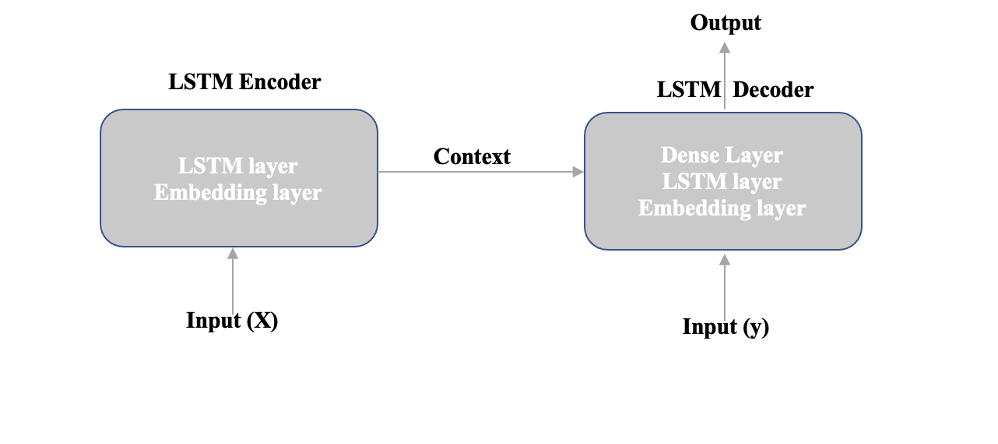

In [ ]:
LSTMoutputDimension=50
vocab_size = 9#max_word
embed_size = 300

In [ ]:
#@title LSTM Encoder-Decoder
def lstmEncoderDecoder(LSTMoutputDimension=LSTMoutputDimension,vocab_size=vocab_size,embed_size=embed_size, dropout=0.0):
      # Define an input sequence and process it.
    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32,name='encoder_inputs')
    embeddings = keras.layers.Embedding(vocab_size, embed_size)
    encoder_embeddings = embeddings(encoder_inputs)

    encoder_lstm=LSTM(512, return_state=True)
    LSTM_outputs, state_h, state_c = encoder_lstm(encoder_embeddings)

    encoder_states = [state_h, state_c]

    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32,name='decoder_inputs')
    decoder_embeddings = embeddings(decoder_inputs)
    decoder_lstm = LSTM(512, return_sequences=True, return_state=True, name='decoder_lstm')

    # Set up the decoder, using `context vector` as initial state.
    decoder_outputs, _, _ = decoder_lstm(decoder_embeddings,
                                          initial_state=encoder_states)
    print(decoder_outputs.shape)
    #complete the decoder model by adding a Dense layer with Softmax activation function
    decoder_dense = Dense(200,  name='decoder_dense1')
    decoder_outputs1 = decoder_dense(decoder_outputs)
    dropout=keras.layers.Dropout(dropout)(decoder_outputs1)
    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(dropout)
    print(decoder_outputs.shape)
    # put together
    model_encoder_decoder= Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_decoder')
    return model_encoder_decoder

In [ ]:
model=lstmEncoderDecoder(dropout=0.9)

(None, None, 512)
(None, None, 9)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) #metric

In [ ]:
model.summary()

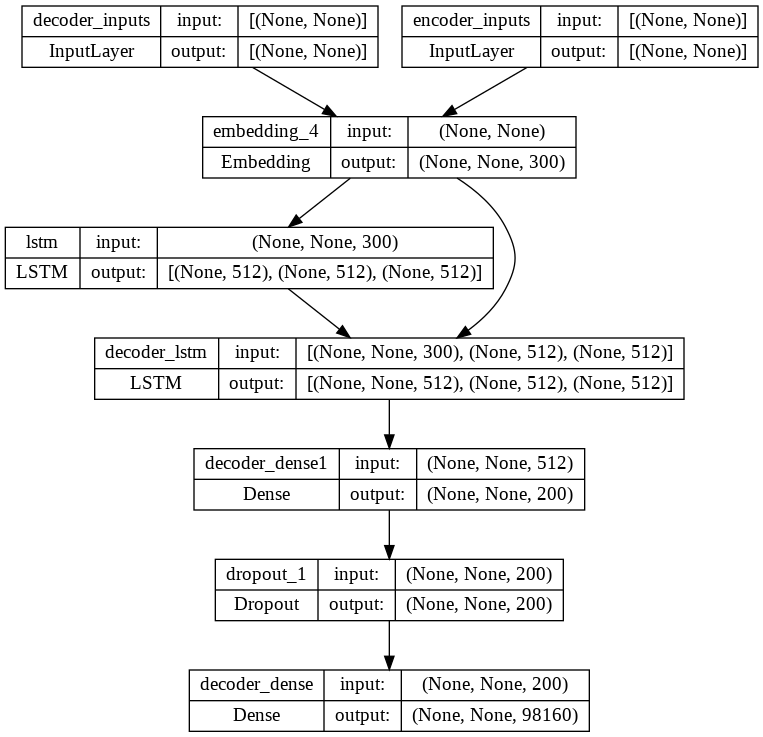

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
!kill 779
%tensorboard --logdir logs

In [ ]:
epochs=20
history=model.fit(train_ds,
          batch_size=10,
          epochs=epochs,validation_data=valid_ds,
          callbacks=[my_callbacks],shuffle=True
          )

In [ ]:
model.evaluate(test_ds_2)

1/1 [==============================] - 0s 343ms/step - loss: 0.3074 - accuracy: 0.9581


[0.30740606784820557, 0.9581249952316284]

In [ ]:
model.save('/content/drive/MyDrive/websecuritymodel/m2')

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/websecuritymodel/m2',compile=False)

## Models Inference

In [ ]:
#@title Transformer Prediction
y1=transformer.predict(test_ds_3)

1/1 [==============================] - 1s 509ms/step


In [ ]:
#@title LSTM Encoder-Decoder Prediction
y2=model.predict(test_ds_3)

In [ ]:
#@title Decoding The Pridicted Results
# mapping the predicte output to its original words
i=12
y_predict=np.argmax(y1[i], axis=-1) # y2
vocab=y_vectorization.get_vocabulary()
vocab_index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = 40

#pred_list = []
for words in y_predict:
  #pred_list.append(vocab_index_lookup[words])
  print(vocab_index_lookup[words], end=' ')


In [ ]:
#test_ds = make_dataset(X[98001:],y[98001:])

In [ ]:
X[98012]

'jessica walk dog home'

In [ ]:
y[98012]

'start jessica was tired of being stuck in the house all alone she decided to go for a walk she saw a stray dog while she was out walking she decided to take the dog home with her end'

## F1-Score, Precision, and Recall

In [ ]:
y_predict=np.zeros((y_test.shape[0],y_test.shape[1]),dtype=np.int32)
for i in range(len(y_test)):
  y_predict[i,:]=np.argmax(yy2[i], axis=1)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

def compute_metric(y_test,y_predict):
  P=0
  R=0
  F=0
  for i in range(y_test.shape[0]):
      precision, recall, f1, _ = precision_recall_fscore_support(y_test[i], y_predict[i], average='weighted', labels=np.unique(y_test))
      P+=precision
      R+=recall
      F+=f1
  return {
      'Precision':P/y_predict.shape[0],
      'Recall':R/y_predict.shape[0],
      'F1-Score':F/y_predict.shape[0]}



In [ ]:
compute_metric(y_test,y_predict)

In [ ]:
# Predict
encoder_model = Model(encoder_inputs, encoder_states)

## In-Progress Work.  📚 📖
Building separate models for in inference. Please read the conclusions for more information

In [ ]:
#@title Transformer Prediction from another model
y_vocab = y_vectorization.get_vocabulary()
y_index_lookup = dict(zip(range(len(y_vocab)), y_vocab))
max_decoded_sentence_length = 48

def decode_sequence(input_sentence):
    tokenized_input_sentence = x_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = x_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

In [ ]:
#@title LSTM encoder-model Prediction from another model
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(None,))
decoder_state_input_c = Input(shape=(None,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

## Story generating using Pre-trainded models from HuggingFace

## Tokenization using pretrained models

In [ ]:
!pip install transformers
import transformers
from transformers import AutoTokenizer

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
new_tokenizer = tokenizer.train_new_from_iterator(y, 22000)

In [ ]:
print(new_tokenizer.tokenize(X[0]),end= ' ')# tokenizer after training

['david', 'habit', 'eat'] 

In [ ]:
print(tokenizer.tokenize(y[0]),end= ' ')# tokenizer after training

['david', 'noticed', 'he', 'had', 'put', 'on', 'a', 'lot', 'of', 'weight', 'recently', 'he', 'examined', 'his', 'habits', 'to', 'try', 'and', 'figure', 'out', 'the', 'reason', 'he', 'realized', 'he', 'd', 'been', 'eating', 'too', 'much', 'fast', 'food', 'lately'] 

In [ ]:
# for results visualization
word2id = new_tokenizer.get_vocab()
word2id

In [ ]:
# ### Tokenization
yids=np.zeros((len(y),maxlen),dtype=np.int32)
#xmasks=np.zeros((len(y),maxlen),dtype=np.int32)
#x_words_id=np.zeros((len(y),maxlen),dtype=np.int32)
for i, sequence in enumerate(y):
  tokens=new_tokenizer.encode_plus(sequence,max_length=maxlen,padding='max_length',
                               truncation=True,add_special_tokens=True,return_attention_mask=False
                               ,return_token_type_ids=True,return_tensors='tf')
  yids[i,:]=tokens['input_ids']
 # xids[i,:],xmasks[i,:],x_words_id[i,:]=tokens['input_ids'],tokens['attention_mask'],tokens['token_type_ids']

In [ ]:
# ### Tokenization
xids=np.zeros((len(X),10),dtype=np.int32)
xmasks=np.zeros((len(X),10),dtype=np.int32)
x_words_id=np.zeros((len(X),10),dtype=np.int32)
for i, sequence in enumerate(X):
  tokens=new_tokenizer.encode_plus(sequence,max_length=10,padding='max_length',
                               truncation=True,add_special_tokens=True,return_attention_mask=True
                               ,return_token_type_ids=True,return_tensors='tf')
  xids[i,:],xmasks[i,:],x_words_id[i,:]=tokens['input_ids'],tokens['attention_mask'],tokens['token_type_ids']

In [ ]:
new_tokenizer.get_vocab()

In [ ]:
tokens = new_tokenizer.tokenize(X[0])
print(tokens)
new_tokenizer.convert_tokens_to_ids(tokens)

['▁David', ',', '▁habit', ',', '▁eat']


[1030, 2, 2117, 2, 1433]

In [ ]:
tokens = new_tokenizer.tokenize('energetic')
print(tokens)
new_tokenizer.convert_tokens_to_ids(tokens)

['▁energ', 'etic']


[2122, 6263]

In [ ]:
xids[0]

array([1030,    2, 2117,    2, 1433,    1,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
n=5
print(xids[n])
yids[n]

[6488  105  110    2 2252    2 2122 6263    1    0]


array([6488,  105,  110,  103,  106,  275,  106,  566,  105,  122,  133,
        103,  104,  324,  112,  109,  280, 2828, 2562, 6488,  105,  110,
        188,  103,  104, 2252,  103,  105,  589,  109,  405,  295,  184,
        541,  112,  109, 2828, 2562,  178,  109,  110,  390,  105, 6488,
        105,  110,    1], dtype=int32)

## Hugging Face Models-Pretrained model

In [ ]:
#model
from transformers import BertConfig
config = BertConfig.from_pretrained("t5-small")

In [ ]:
from transformers import TFAutoModel
bert=TFAutoModel.from_pretrained('google/flan-t5-xxl',config=config,num_labels=num_tags)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
xids.shape

(98166, 10)

In [ ]:
def storybert(dropout_rate=0.0,num_tags=maxlen):
  # build the NN around BERT (we have two inputs): they must match the tags that we defined in the map function
  input_ids=keras.layers.Input(shape=(10,),name='input_ids',dtype='int32')
  att_masks=keras.layers.Input(shape=(10,),name='attention_mask',dtype='int32')
  #x_words_id=keras.layers.Input(shape=(maxlen,),name='x_words_id',dtype='int32')
  embedding=bert([input_ids,att_masks])[1]# ,x_words_id]) # bert expect 2 inputs and return 2 output--> we need only output index 0 (the last hidden state)
  #x=keras.layers.BatchNormalization()(embedding['last_hidden_state'])
  x=keras.layers.BatchNormalization()(embedding)
  print(x.shape)
  x=keras.layers.Dense(100,activation='relu')(x)
  x=keras.layers.Dropout(dropout_rate)(x)
  y=keras.layers.Dense(num_tags,activation='softmax')(x)
  print(y.shape)
  model=keras.Model(inputs=[input_ids,att_masks],outputs=[y])
  return model


In [ ]:
model=storybert()

(None, 768)
(None, 47)


In [ ]:
yids.shape

(98166, 47)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:
history = model.fit(x=[tf.constant(xids),tf.constant(xmasks)] , y=tf.constant(yids),
                    validation_split=0.2,
                    epochs=1,
                    batch_size=10,verbose=1)

In [ ]:
model.evaluate([X_test,X_test_mask],y_test) # 13

In [ ]:
p=model.predict([X_test,X_test_mask])